# Overview
Here, I want to run a set of simulations in which the model tries to maximize the demand met within a certain distance.
It is limited by the number of hubs it can build and the capactiy of each hub
Variables to change:
1. Number of hubs to build
2. Maximum distance the people can travel
I suspect that, as I increase the maximum distance, the hubs that will be built will be larger and more distant than for smaller distances.


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import importlib
from data_cleaning import hub_occ_dict
from data_cleaning import hub_sqft_dict
from data_cleaning import heatdays_df
from data_cleaning import cengeo_pop_dict
from data_cleaning import bg_ces_df
bg_ces_df.set_index("GISJOIN",inplace=True)
bg_ces_df["GISJOIN"] = bg_ces_df.index

import demand_maximization_models as dem_models

distmatrix_df = pd.read_csv(os.path.join("data","distmatrix_bbox.csv"))
distmatrix_df.rename(columns = {"Unnamed: 0":"GISJOIN"},inplace=True)
distmatrix_df.set_index("GISJOIN",inplace=True)

hubs_df = pd.read_csv(os.path.join("data","candidate_site_campuses_2021-11-17","candidate_sites_campuses.csv"),
                      index_col='id_site')
hub_occ_df = pd.Series(hub_occ_dict)
hub_occ_df.rename("max_occupancy",inplace=True)
hubs_df = hubs_df.merge(hub_occ_df,left_index=True,right_index=True)

blockgroup_gdf = gpd.read_file(os.path.join("data","bg_ca_19","blockgroup_CA_19.shp"))
blockgroup_df = blockgroup_gdf[["INTPTLAT","INTPTLON","GISJOIN"]].copy().set_index("GISJOIN")
blockgroup_gdf = blockgroup_gdf.set_index("GISJOIN")

In [86]:
importlib.reload(dem_models) # in case the code for demand_maximization_models.py is changed

##################USER VARIABLES#########################
max_hubs_list =[50,100]
max_distance_list = [1,3,5]
##################END OF USER VARIABLES#########################

prop_served_dict_basic = dict()
hub_yn_dict_basic = dict()

for max_hubs in max_hubs_list:
    for max_distance in max_distance_list:
        prop_served_dict_basic[(max_hubs,max_distance)], hub_yn_dict_basic[(max_hubs,max_distance)] = dem_models.build_demand_max_model(max_hubs,
                                   max_distance,
                                   distmatrix_df,
                                   hub_sqft_dict,
                                   cengeo_pop_dict,
                                   hub_occ_dict,
                                   bg_ces_df,
                                   min_fraction_covered = 0)
#         run_string = "Contra_"+str(max_hubs)+"hubs"+str(max_distance)+"miles_max_new"
#         try:
#             os.mkdir(os.path.join("results",run_string))
#         except OSError as error:
#             print(error)
#         prop_served_dict[(max_hubs,max_distance)].to_csv(os.path.join("results",
#                                                                       run_string,
#                                                                       "var_prop_served.csv"))
#         hub_yn_dict[(max_hubs,max_distance)].to_csv(os.path.join("results",
#                                                                  run_string,
#                                                                  "var_hub_yn.csv"))


Time to solve model:  0.41704529999697115
Time to solve model:  1.4123963000020012
Time to solve model:  1.3850591000082204
Time to solve model:  0.5312603000056697
Time to solve model:  1.5984065999946324
Time to solve model:  1.9403310000052443


# Beginning of Visualization for Basic Model

## Map


In [138]:
import plotly.graph_objects as go # or plotly.express as px
import plotly.express as px
################USER VARIABLES#####################
# Change this section however you like, it just needs to get the
# two variables var_prop_served and var_hub_yn in order to work
max_hubs_entry = 0
max_distance_entry = 2
max_hubs = max_hubs_list[max_hubs_entry]
max_distance = max_distance_list[max_distance_entry]
var_prop_served = prop_served_dict_basic[(max_hubs,max_distance)]
var_hub_yn = hub_yn_dict_basic[(max_hubs,max_distance)]
###################################################

var_hub_yn = np.round(var_hub_yn)
var_prop_served.mask(var_prop_served<0.000000001,0,inplace=True)
# var_prop_served.iloc[var_prop_served.loc[:,:]<0.0000000001] = 0
hubs_df["info"] = [row[1]["name_site"] + 
                   ", Maximum occupancy: " + str(row[1]["max_occupancy"]) +
                   ", id: " + str(row[0])
                   for row in hubs_df.iterrows()]

hubs_not_built = var_hub_yn.index[var_hub_yn[0]==0]
hubs_not_built = [str(h) for h in hubs_not_built if str(h) in var_prop_served.columns]
hubs_not_built_df = hubs_df.loc[hubs_not_built,:]

hubs_built = var_hub_yn.index[var_hub_yn[0]==1]
hubs_built = [str(h) for h in hubs_built if str(h) in var_prop_served.columns]
hubs_built_df = hubs_df.loc[hubs_built,:]

blockgroup_df_local = blockgroup_df.loc[var_prop_served.index.to_list(),:].copy()
blockgroup_df_local = blockgroup_df_local.merge(bg_ces_df,left_index=True,right_index=True)

total_fraction_demand_met = var_prop_served.sum(axis=1)
total_fraction_demand_met.rename("total_fraction_demand_met",inplace=True)
blockgroup_df_local = blockgroup_df_local.merge(total_fraction_demand_met,left_index=True,right_index=True)

# blockgroup_df_local.set_index("GISJOIN",inplace=True)

dists = dict()
for r in range(distmatrix_df.shape[0]):
    idx_real = np.where(distmatrix_df.iloc[r,:].notnull())
    dist_dict = dict(distmatrix_df.iloc[r,idx_real[0]])
    dists[distmatrix_df.index[r]] = dist_dict

pairs = dict()
for r in range(var_prop_served.shape[0]):
    idx_real = np.where((var_prop_served.iloc[r,:].notnull())&(var_prop_served.iloc[r,:]>0))
    pair_dict = dict(var_prop_served.iloc[r,idx_real[0]])
    pairs[var_prop_served.index[r]] = pair_dict

# BUILT HUBS MARKERS
fig_map = go.Figure(go.Scattermapbox(lat=hubs_built_df["LAT"], lon=hubs_built_df["LON"],
                                 mode='markers',
                                marker=go.scattermapbox.Marker(
                                    size=20*np.sqrt(hubs_built_df["SQFT_ROOF"])/np.max(np.sqrt(hubs_built_df["SQFT_ROOF"])),
                                    color='rgb(255, 0, 0)',
                                    opacity=1.0,
                                    # symbol = "castle"
                                ),
                                # marker_symbol = 'circle-open',
                                text=hubs_built_df["info"],
                                hoverinfo='text',
                                name = 'Built hubs'
                                 )
                )

# UNBUILT HUBS MARKERS
fig_map.add_trace(go.Scattermapbox(lat=hubs_not_built_df["LAT"], lon=hubs_not_built_df["LON"],
                                    mode='markers',
                                    marker=go.scattermapbox.Marker(
                                        size=20*np.sqrt(hubs_not_built_df["SQFT_ROOF"])/np.max(np.sqrt(hubs_not_built_df["SQFT_ROOF"])),
                                        color='rgb(100, 0, 50)',
                                        opacity=0.5
                                        ),
                                    text=hubs_not_built_df["info"],
                                    hoverinfo='text',
                                    name = 'Unbuilt hubs'
                                    )
                )

# BLOCKGROUP MARKERS
blockgroup_df_local["info"] = ["BG: " + row[0] + 
                               ", CES: " + str(row[1]["SCORE_PCTL_CI_BG"]) +
                               ", Demand met: " + str(row[1]["total_fraction_demand_met"])+
                               ", Total Pop: " + str(row[1]["BLOCKGROUPPOP19"]) for row in blockgroup_df_local.iterrows()]
fig_map.add_trace(go.Scattermapbox(lat=blockgroup_df_local["INTPTLAT"], lon=blockgroup_df_local["INTPTLON"],
                                  mode='markers',
                                  marker=go.scattermapbox.Marker(
                                      size=30 * blockgroup_df_local["BLOCKGROUPPOP19"]/np.max(blockgroup_df_local["BLOCKGROUPPOP19"]),
#                                       size=20,
                                      color='rgb(0, 150, 255)',opacity=0.7
                                ),
                                text=blockgroup_df_local["info"],
                                hoverinfo='text',
                                name = 'Blockgroups'
                                 )
                )

# EDGES CONNECTING HUB AND BLOCKGROUP PAIRS
lons_pairs = []
lats_pairs = []
names_pairs = []
for bg in pairs:
    for hub in pairs[bg]:
        lons_pairs.append(float(blockgroup_df.loc[bg,"INTPTLON"]))
        lats_pairs.append(float(blockgroup_df.loc[bg,"INTPTLAT"]))
        lons_pairs.append((float(blockgroup_df.loc[bg,"INTPTLON"])+float(hubs_df.loc[str(hub),"LON"]))/2)
        lats_pairs.append((float(blockgroup_df.loc[bg,"INTPTLAT"])+float(hubs_df.loc[str(hub),"LAT"]))/2)
        lons_pairs.append(float(hubs_df.loc[str(hub),"LON"]))
        lats_pairs.append(float(hubs_df.loc[str(hub),"LAT"]))
        names_pairs.append(None)
        names_pairs.append("Proportion of demand: " + str(pairs[bg][hub])+", Travel distance: "+str(distmatrix_df.loc[bg,hub]))
        names_pairs.append(None)
        lons_pairs.append(None)
        lats_pairs.append(None)
        names_pairs.append(None)

fig_map.add_trace(go.Scattermapbox(mode = "lines",lon = lons_pairs,lat = lats_pairs,text = names_pairs,
                                   hovertext = names_pairs,
                                   hoverinfo='skip',
    # marker = {'size': 1,'opacity':1.0}), 
    line = {'width':0.5,'color':'rgb(245,245,245)'},    
    name = 'Assigned demand'))

# BACKGROUND MAPS TO CHOOSE FROM
# carto-darkmatter, carto-positron, open-street-map, stamen-terrain, stamen-toner, stamen-watercolor, white-bg

fig_map.update_layout(mapbox=dict(center=dict(lat=38,lon=-122),
                               zoom=9
                               ),
                #   mapbox_style="open-street-map",
                  mapbox_style="carto-darkmatter",
                  height = 700,
                  title = "Maximum hub: " + str(max_hubs) + ", Maximum travel distance: " + str(max_distance) + " miles" 
                  )

fig_map.show()
# fig_map.write_html("tmp.html")

## Some statistics
1. Histograms of how much demand is being met across all blockgroups (is it all or nothing or a mixture?)
2. Cumulative distribution function of the size of the built hubs (are bigger or smaller hubs being built?)
3. CES score of the population being served versus not served
4. Cumulative distribution of the distance travelled

In [122]:
# blockgroup_df_local 
bg_ces_df
# = blockgroup_df_local.merge(bg_ces_df,on="GISJOIN")

,Unnamed: 0,BLOCKGROUPPOP19,BLOCKGROUPHH19,PCT_LESSHS,PCT_UNEMP,PCT_RENT,PCT_LINGISO,PCT_POV,RATE_ASTH,RATE_LBW,...,PCTL_POV,PCTL_ASTH,PCTL_LBW,PCTL_CVD,SCORE_SENSPOP,SCORE_SES,SCORE_POP,SCORE_CI_BG,SCORE_PCTL_CI_BG,GISJOIN
GISJOIN,,,,,,,,,,,,,,,,,,,,,
G06000104001001,0,3120,1293,0.032682,0.031484,0.110596,0.011601,0.104227,15.65,3.85,...,17.677620,4.416908,22.664853,1.265058,9.448940,24.754953,1.710195,7.103602,5.426992,G06000104001001
G06000104002001,1,990,422,0.000000,0.026582,0.270142,0.000000,0.076768,20.47,4.05,...,11.352124,9.924010,27.701487,14.837442,17.487647,20.729127,1.910839,7.704704,6.609965,G06000104002001
G06000104002002,2,1017,425,0.008516,0.018519,0.489412,0.000000,0.135458,20.47,4.05,...,24.726155,9.924010,27.701487,14.837442,17.487647,26.899484,2.219357,8.948680,9.260858,G06000104002002
G06000104003001,3,1134,405,0.000000,0.045673,0.348148,0.000000,0.022046,30.88,3.78,...,2.117158,26.501446,21.353047,20.325115,22.726536,25.775764,2.425115,10.848579,13.867542,G06000104003001
G06000104003002,4,1237,697,0.092843,0.054608,0.703013,0.000000,0.098580,30.88,3.78,...,16.309477,26.501446,21.353047,20.325115,22.726536,45.334691,3.403061,15.223353,25.667041,G06000104003002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G06011500410005,23187,444,210,0.000000,0.000000,0.180952,0.000000,0.360360,40.86,4.85,...,64.341689,42.925608,49.214671,59.766418,50.635566,21.268328,3.595195,20.167832,38.455228,G06011500410005
G06011500411001,23188,1147,459,0.055819,0.022801,0.289760,0.002179,0.255449,19.08,3.85,...,48.469498,7.998359,22.664853,10.845818,13.836344,35.209386,2.452286,10.608861,13.293325,G06011500411001
G06011500411002,23189,1472,742,0.067273,0.000000,0.247978,0.044474,0.332880,19.08,3.85,...,60.523012,7.998359,22.664853,10.845818,13.836344,35.307102,2.457172,10.629997,13.327865,G06011500411002


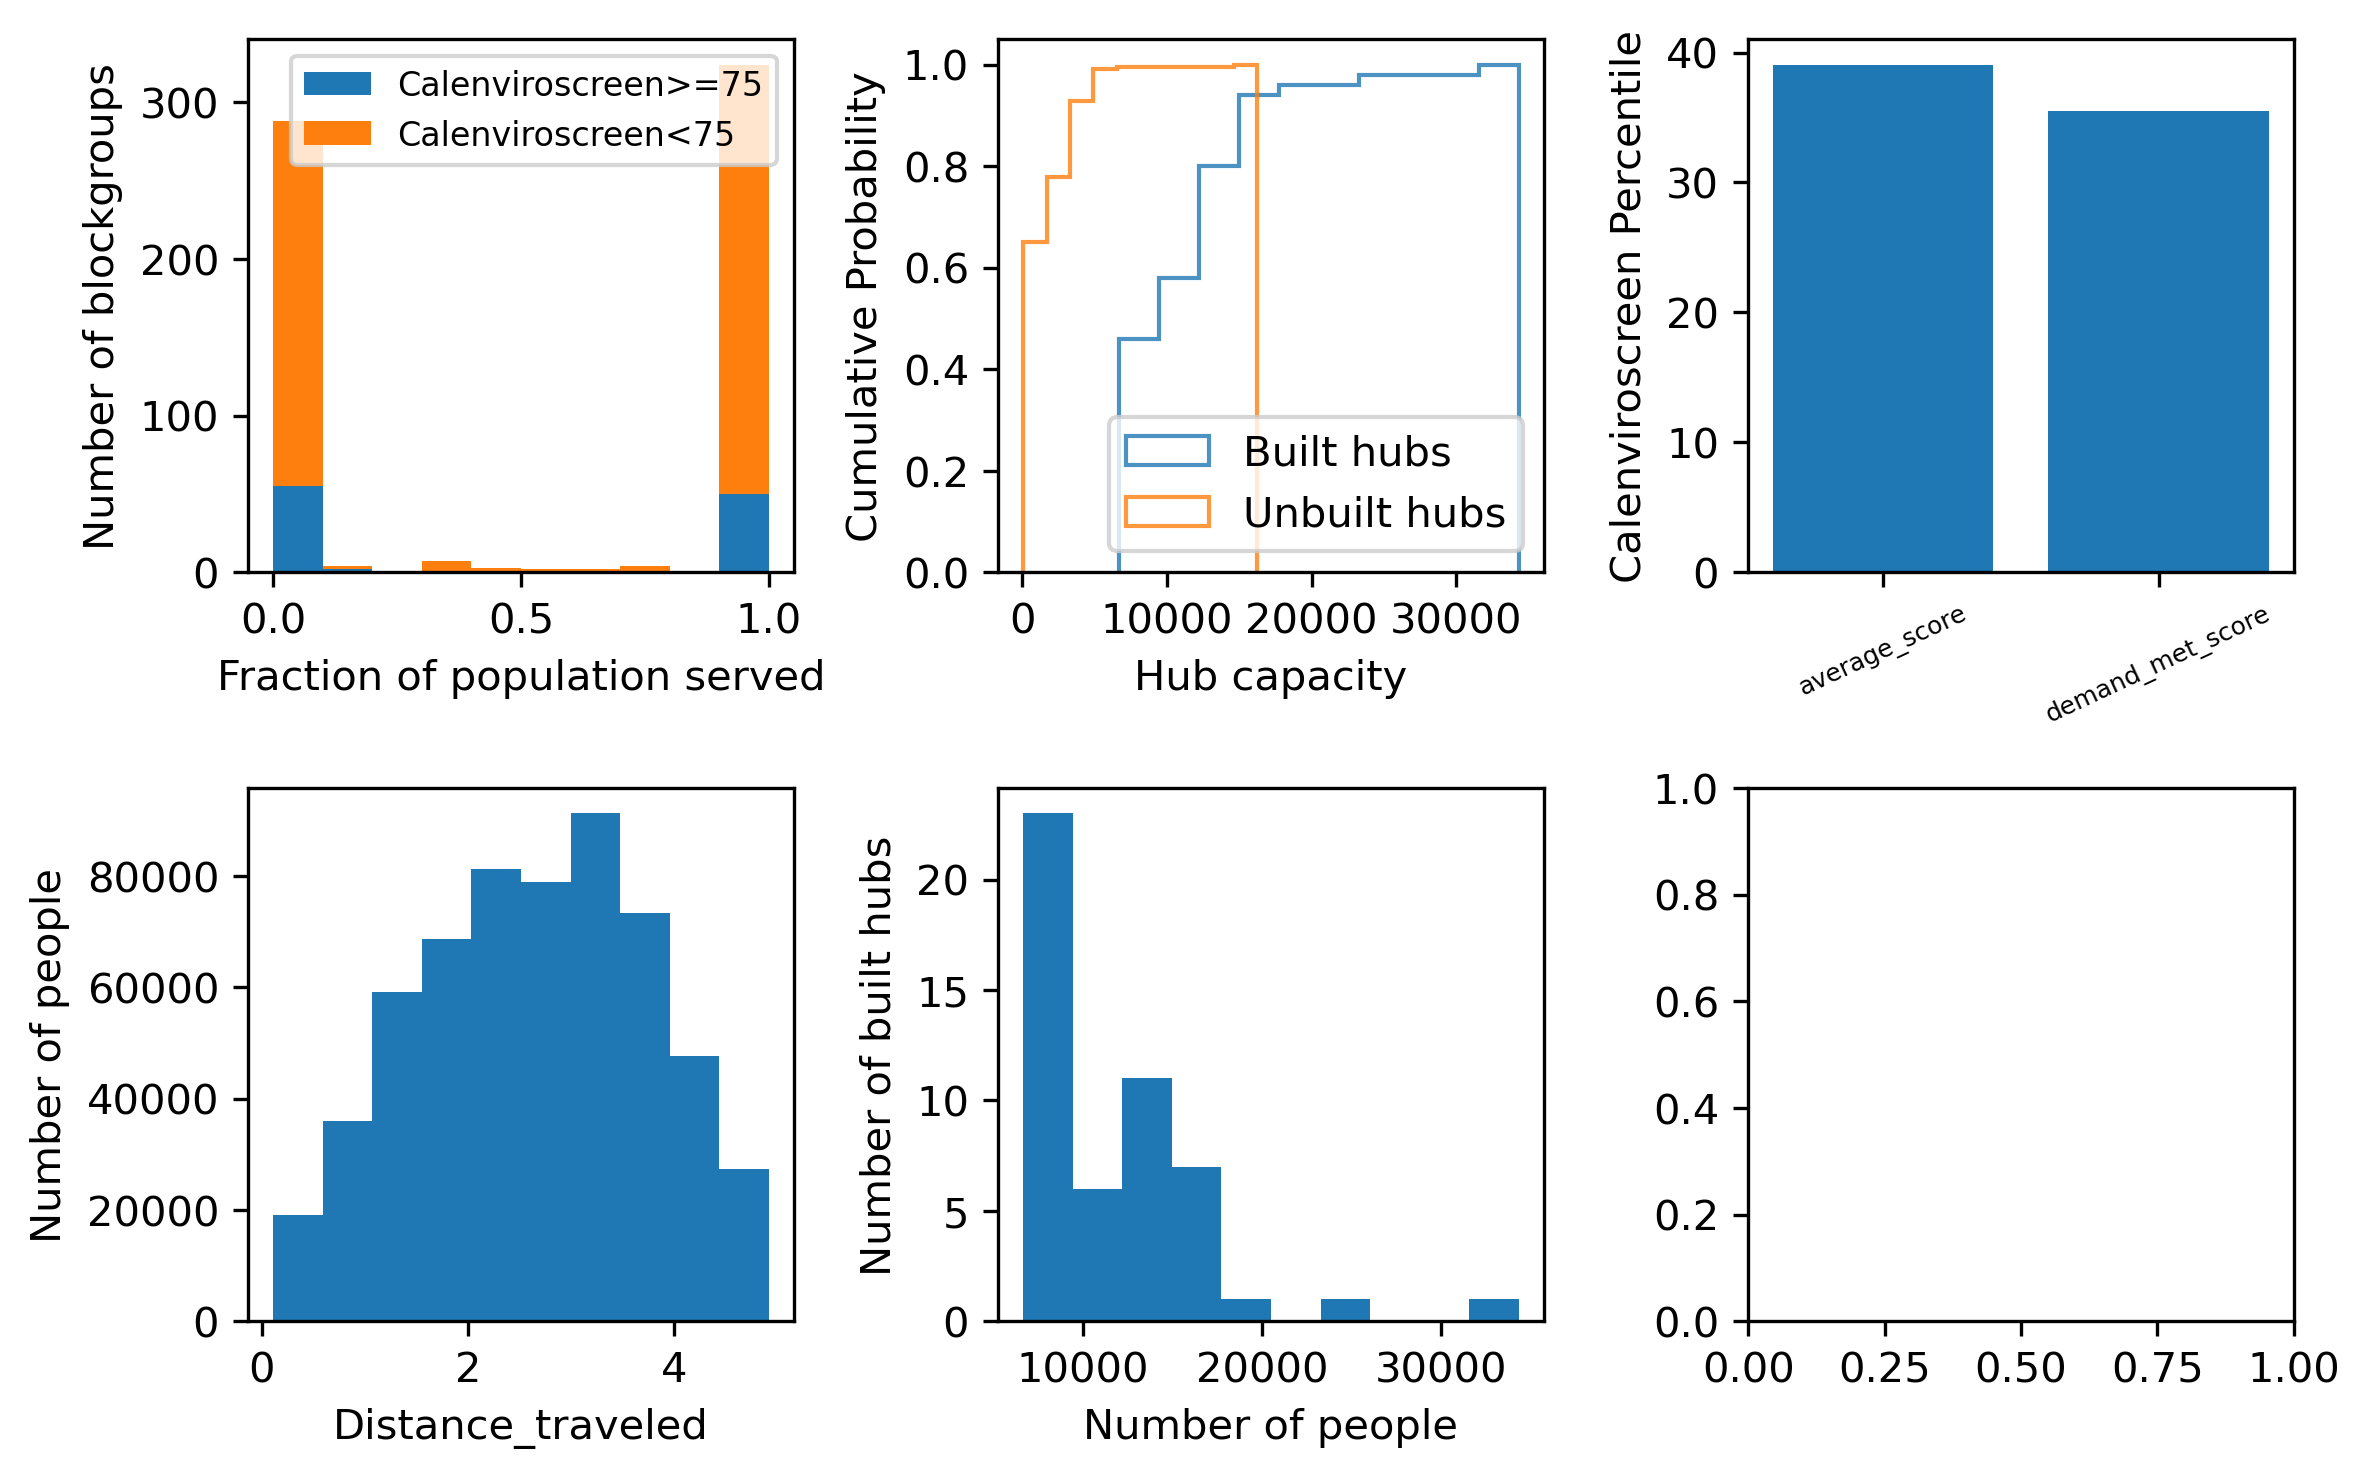

In [141]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3,figsize = (8,5),dpi=300)

################USER VARIABLES#####################
# Change this section however you like, it just needs to get the
# two variables var_prop_served and var_hub_yn in order to work
max_hubs_entry = 0
max_distance_entry = 2
max_hubs = max_hubs_list[max_hubs_entry]
max_distance = max_distance_list[max_distance_entry]
var_prop_served = prop_served_dict_basic[(max_hubs,max_distance)]
var_hub_yn = hub_yn_dict_basic[(max_hubs,max_distance)]
####################################################
# GETTING DATA FROM VARIABLES
hubs_not_built = var_hub_yn.index[var_hub_yn[0]==0]
hubs_not_built = [str(h) for h in hubs_not_built if str(h) in var_prop_served.columns]
hubs_not_built_df = hubs_df.loc[hubs_not_built,:]

hubs_built = var_hub_yn.index[var_hub_yn[0]==1]
hubs_built = [str(h) for h in hubs_built if str(h) in var_prop_served.columns]
hubs_built_df = hubs_df.loc[hubs_built,:]

blockgroup_df_local = blockgroup_df.loc[var_prop_served.index.to_list(),:].copy()
blockgroup_df_local = blockgroup_df_local.merge(bg_ces_df,left_index=True,right_index=True)
# blockgroup_df_local.set_index("GISJOIN",inplace=True)

####################################################
# BLOCKGROUP TOTAL DEMAND MET HISTOGRAMS
EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]>=75]["GISJOIN"].to_list()]
not_EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]<75]["GISJOIN"].to_list()]

axs[0,0].hist([var_prop_served.loc[EJ_bg].sum(axis=1),
                var_prop_served.loc[not_EJ_bg].sum(axis=1)],
                label = ("Calenviroscreen>=75","Calenviroscreen<75"),
                stacked=True, # histtype=u'step'
                )
axs[0,0].legend(fontsize = 8)
axs[0,0].set_xlabel("Fraction of population served")
axs[0,0].set_ylabel("Number of blockgroups")

####################################################
# CDF OF HUB CAPCITIES
axs[0,1].hist([hub_occ_dict[hub] for hub in hubs_built], density=True, cumulative=True, label='Built hubs',histtype='step', alpha=0.8)
axs[0,1].hist([hub_occ_dict[hub] for hub in hubs_not_built], density=True, cumulative=True, label='Unbuilt hubs',histtype='step', alpha=0.8)
axs[0,1].legend(loc='lower right')
axs[0,1].set_xlabel("Hub capacity")
axs[0,1].set_ylabel("Cumulative Probability")
plt.tight_layout()

####################################################
# Calenviroscreen percentiles
total_fraction_demand_met = var_prop_served.sum(axis=1)
total_fraction_demand_met.rename("total_fraction_demand_met",inplace=True)
blockgroup_df_local = blockgroup_df_local.merge(total_fraction_demand_met,left_index=True,right_index=True)
score_dict = dict()
score_dict["average_score"] = np.sum(blockgroup_df_local["SCORE_PCTL_CI_BG"]*(blockgroup_df_local["BLOCKGROUPPOP19"]/np.sum(blockgroup_df_local["BLOCKGROUPPOP19"])))
score_dict["demand_met_score"] = np.sum(blockgroup_df_local["SCORE_PCTL_CI_BG"]*((blockgroup_df_local["total_fraction_demand_met"]*blockgroup_df_local["BLOCKGROUPPOP19"])/(np.sum(blockgroup_df_local["total_fraction_demand_met"]*blockgroup_df_local["BLOCKGROUPPOP19"]))))
axs[0,2].bar(range(len(score_dict)),list(score_dict.values()),tick_label = list(score_dict.keys()))
axs[0,2].set_ylabel("Calenviroscreen Percentile")
axs[0,2].tick_params(axis='x', labelrotation= 25,labelsize=6)

####################################################
# Distance travelled
dist_list = []
pop_list = []
for bg,row in var_prop_served.iterrows():
    for hub in row[row>0].index:
        dist_list.append(distmatrix_df.loc[bg,hub])
        pop_list.append(cengeo_pop_dict[bg]*var_prop_served.loc[bg,hub])

axs[1,0].hist(dist_list,weights = pop_list)
axs[1,0].set_ylabel("Number of people")
axs[1,0].set_xlabel("Distance_traveled")

####################################################
# People per hub
hub_pop_list = []
for hub,row in var_prop_served.iteritems():
    pop = 0
    for bg in row[row>0].index:
        pop+=cengeo_pop_dict[bg]*var_prop_served.loc[bg,hub]
    if pop>0:
        hub_pop_list.append(pop)

axs[1,1].hist(hub_pop_list)
axs[1,1].set_ylabel("Number of built hubs")
axs[1,1].set_xlabel("Number of people")

plt.tight_layout()
plt.savefig("plots_max_distance"+str(max_distance)+".png")

# Maximum cost and CES score prioritization model

In [ ]:
importlib.reload(dem_models) # in case the code for demand_maximization_models.py is changed

##################USER VARIABLES#########################
max_cost_list = [500000,
                 800000,
                 1200000]

max_distance_list = [3]

ces_multiplier_list = [0.0,0.25,0.5]
##################END OF USER VARIABLES#########################

prop_served_dict = dict()
hub_yn_dict = dict()

for max_cost in max_cost_list:
    for max_distance in max_distance_list:
        for ces_multiplier in ces_multiplier_list:
            prop_served_dict[(max_cost,max_distance,ces_multiplier)], hub_yn_dict[(max_cost,max_distance,ces_multiplier)] = \
                            dem_models.build_demand_max_ces_cost_model(max_cost,
                                                                       max_distance,
                                                                       distmatrix_df,
                                                                       hub_sqft_dict,
                                                                       cengeo_pop_dict,
                                                                       hub_occ_dict,
                                                                       bg_ces_df,
                                                                       ces_multiplier = ces_multiplier,
                                                                       cost_per_hub = 100,
                                                                       cost_per_capita = 1)
    #         run_string = "Contra_"+str(max_hubs)+"hubs"+str(max_distance)+"miles_max_new"
    #         try:
    #             os.mkdir(os.path.join("results",run_string))
    #         except OSError as error:
    #             print(error)
#             prop_served_dict[(max_hubs,max_distance)].to_csv(os.path.join("results",
#                                                                           run_string,
#                                                                           "var_prop_served.csv"))
#             hub_yn_dict[(max_hubs,max_distance)].to_csv(os.path.join("results",
#                                                                      run_string,
#                                                                      "var_hub_yn.csv"))


Time to solve model:  1.3244862999999896
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Model was proven to be infeasible.
Time to solve model:  1.8539827000058722
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Model was proven to be infeasible.
Time to solve model:  1.3455015000072308


In [170]:
import plotly.graph_objects as go # or plotly.express as px
import plotly.express as px
################USER VARIABLES#####################
# Change this section however you like, it just needs to get the
# two variables var_prop_served and var_hub_yn in order to work
max_cost_entry = 1
max_distance_entry = 0
ces_multiplier_entry = 1

max_cost = max_cost_list[max_cost_entry]
max_distance = max_distance_list[max_distance_entry]
ces_multiplier = ces_multiplier_list[ces_multiplier_entry]
var_prop_served = prop_served_dict[(max_cost,max_distance,ces_multiplier)]
var_hub_yn = hub_yn_dict[(max_cost,max_distance,ces_multiplier)]
###################################################
var_hub_yn = np.round(var_hub_yn)
var_prop_served.mask(var_prop_served<0.000000001,0,inplace=True)
# var_prop_served.iloc[var_prop_served.loc[:,:]<0.0000000001] = 0
hubs_df["info"] = [row[1]["name_site"] + 
                   ", Maximum occupancy: " + str(row[1]["max_occupancy"]) +
                   ", id: " + str(row[0])
                   for row in hubs_df.iterrows()]

hubs_not_built = var_hub_yn.index[var_hub_yn[0]==0]
hubs_not_built = [str(h) for h in hubs_not_built if str(h) in var_prop_served.columns]
hubs_not_built_df = hubs_df.loc[hubs_not_built,:]

hubs_built = var_hub_yn.index[var_hub_yn[0]==1]
hubs_built = [str(h) for h in hubs_built if str(h) in var_prop_served.columns]
hubs_built_df = hubs_df.loc[hubs_built,:]

blockgroup_df_local = blockgroup_df.loc[var_prop_served.index.to_list(),:].copy()
blockgroup_df_local = blockgroup_df_local.merge(bg_ces_df,left_index=True,right_index=True)

total_fraction_demand_met = var_prop_served.sum(axis=1)
total_fraction_demand_met.rename("total_fraction_demand_met",inplace=True)
blockgroup_df_local = blockgroup_df_local.merge(total_fraction_demand_met,left_index=True,right_index=True)

# blockgroup_df_local.set_index("GISJOIN",inplace=True)

dists = dict()
for r in range(distmatrix_df.shape[0]):
    idx_real = np.where(distmatrix_df.iloc[r,:].notnull())
    dist_dict = dict(distmatrix_df.iloc[r,idx_real[0]])
    dists[distmatrix_df.index[r]] = dist_dict

pairs = dict()
for r in range(var_prop_served.shape[0]):
    idx_real = np.where((var_prop_served.iloc[r,:].notnull())&(var_prop_served.iloc[r,:]>0))
    pair_dict = dict(var_prop_served.iloc[r,idx_real[0]])
    pairs[var_prop_served.index[r]] = pair_dict

# BUILT HUBS MARKERS
fig_map = go.Figure(go.Scattermapbox(lat=hubs_built_df["LAT"], lon=hubs_built_df["LON"],
                                 mode='markers',
                                marker=go.scattermapbox.Marker(
                                    size=20*np.sqrt(hubs_built_df["SQFT_ROOF"])/np.max(np.sqrt(hubs_built_df["SQFT_ROOF"])),
                                    color='rgb(255, 0, 0)',
                                    opacity=1.0,
                                    # symbol = "castle"
                                ),
                                # marker_symbol = 'circle-open',
                                text=hubs_built_df["info"],
                                hoverinfo='text',
                                name = 'Built hubs'
                                 )
                )

# UNBUILT HUBS MARKERS
fig_map.add_trace(go.Scattermapbox(lat=hubs_not_built_df["LAT"], lon=hubs_not_built_df["LON"],
                                    mode='markers',
                                    marker=go.scattermapbox.Marker(
                                        size=20*np.sqrt(hubs_not_built_df["SQFT_ROOF"])/np.max(np.sqrt(hubs_not_built_df["SQFT_ROOF"])),
                                        color='rgb(100, 0, 50)',
                                        opacity=0.5
                                        ),
                                    text=hubs_not_built_df["info"],
                                    hoverinfo='text',
                                    name = 'Unbuilt hubs'
                                    )
                )

# BLOCKGROUP MARKERS
blockgroup_df_local["info"] = ["BG: " + row[0] + 
                               ", CES: " + str(row[1]["SCORE_PCTL_CI_BG"]) +
                               ", Demand met: " + str(row[1]["total_fraction_demand_met"])+
                               ", Total Pop: " + str(row[1]["BLOCKGROUPPOP19"]) for row in blockgroup_df_local.iterrows()]
fig_map.add_trace(go.Scattermapbox(lat=blockgroup_df_local["INTPTLAT"], lon=blockgroup_df_local["INTPTLON"],
                                  mode='markers',
                                  marker=go.scattermapbox.Marker(
                                      size=30 * blockgroup_df_local["BLOCKGROUPPOP19"]/np.max(blockgroup_df_local["BLOCKGROUPPOP19"]),
#                                       size=20,
                                      color='rgb(0, 150, 255)',opacity=0.7
                                ),
                                text=blockgroup_df_local["info"],
                                hoverinfo='text',
                                name = 'Blockgroups'
                                 )
                )

# EDGES CONNECTING HUB AND BLOCKGROUP PAIRS
lons_pairs = []
lats_pairs = []
names_pairs = []
for bg in pairs:
    for hub in pairs[bg]:
        lons_pairs.append(float(blockgroup_df.loc[bg,"INTPTLON"]))
        lats_pairs.append(float(blockgroup_df.loc[bg,"INTPTLAT"]))
        lons_pairs.append((float(blockgroup_df.loc[bg,"INTPTLON"])+float(hubs_df.loc[str(hub),"LON"]))/2)
        lats_pairs.append((float(blockgroup_df.loc[bg,"INTPTLAT"])+float(hubs_df.loc[str(hub),"LAT"]))/2)
        lons_pairs.append(float(hubs_df.loc[str(hub),"LON"]))
        lats_pairs.append(float(hubs_df.loc[str(hub),"LAT"]))
        names_pairs.append(None)
        names_pairs.append("Proportion of demand: " + str(pairs[bg][hub])+", Travel distance: "+str(distmatrix_df.loc[bg,hub]))
        names_pairs.append(None)
        lons_pairs.append(None)
        lats_pairs.append(None)
        names_pairs.append(None)

fig_map.add_trace(go.Scattermapbox(mode = "lines",lon = lons_pairs,lat = lats_pairs,text = names_pairs,
                                   hovertext = names_pairs,
                                   hoverinfo='skip',
    # marker = {'size': 1,'opacity':1.0}), 
    line = {'width':0.5,'color':'rgb(245,245,245)'},    
    name = 'Assigned demand'))

# BACKGROUND MAPS TO CHOOSE FROM
# carto-darkmatter, carto-positron, open-street-map, stamen-terrain, stamen-toner, stamen-watercolor, white-bg

fig_map.update_layout(mapbox=dict(center=dict(lat=38,lon=-122),
                               zoom=9
                               ),
                #   mapbox_style="open-street-map",
                  mapbox_style="carto-darkmatter",
                  height = 700,
                  title = "Maximum cost: " + str(max_cost) + ", Maximum travel distance: " + str(max_distance) + " miles" + ", CES multiplier: " + str(ces_multiplier)
                  )

fig_map.show()
fig_map.write_html("cost_"+str(max_cost)+"_dist_"+str(max_distance)+"_ces_"+str(ces_multiplier)+".html")

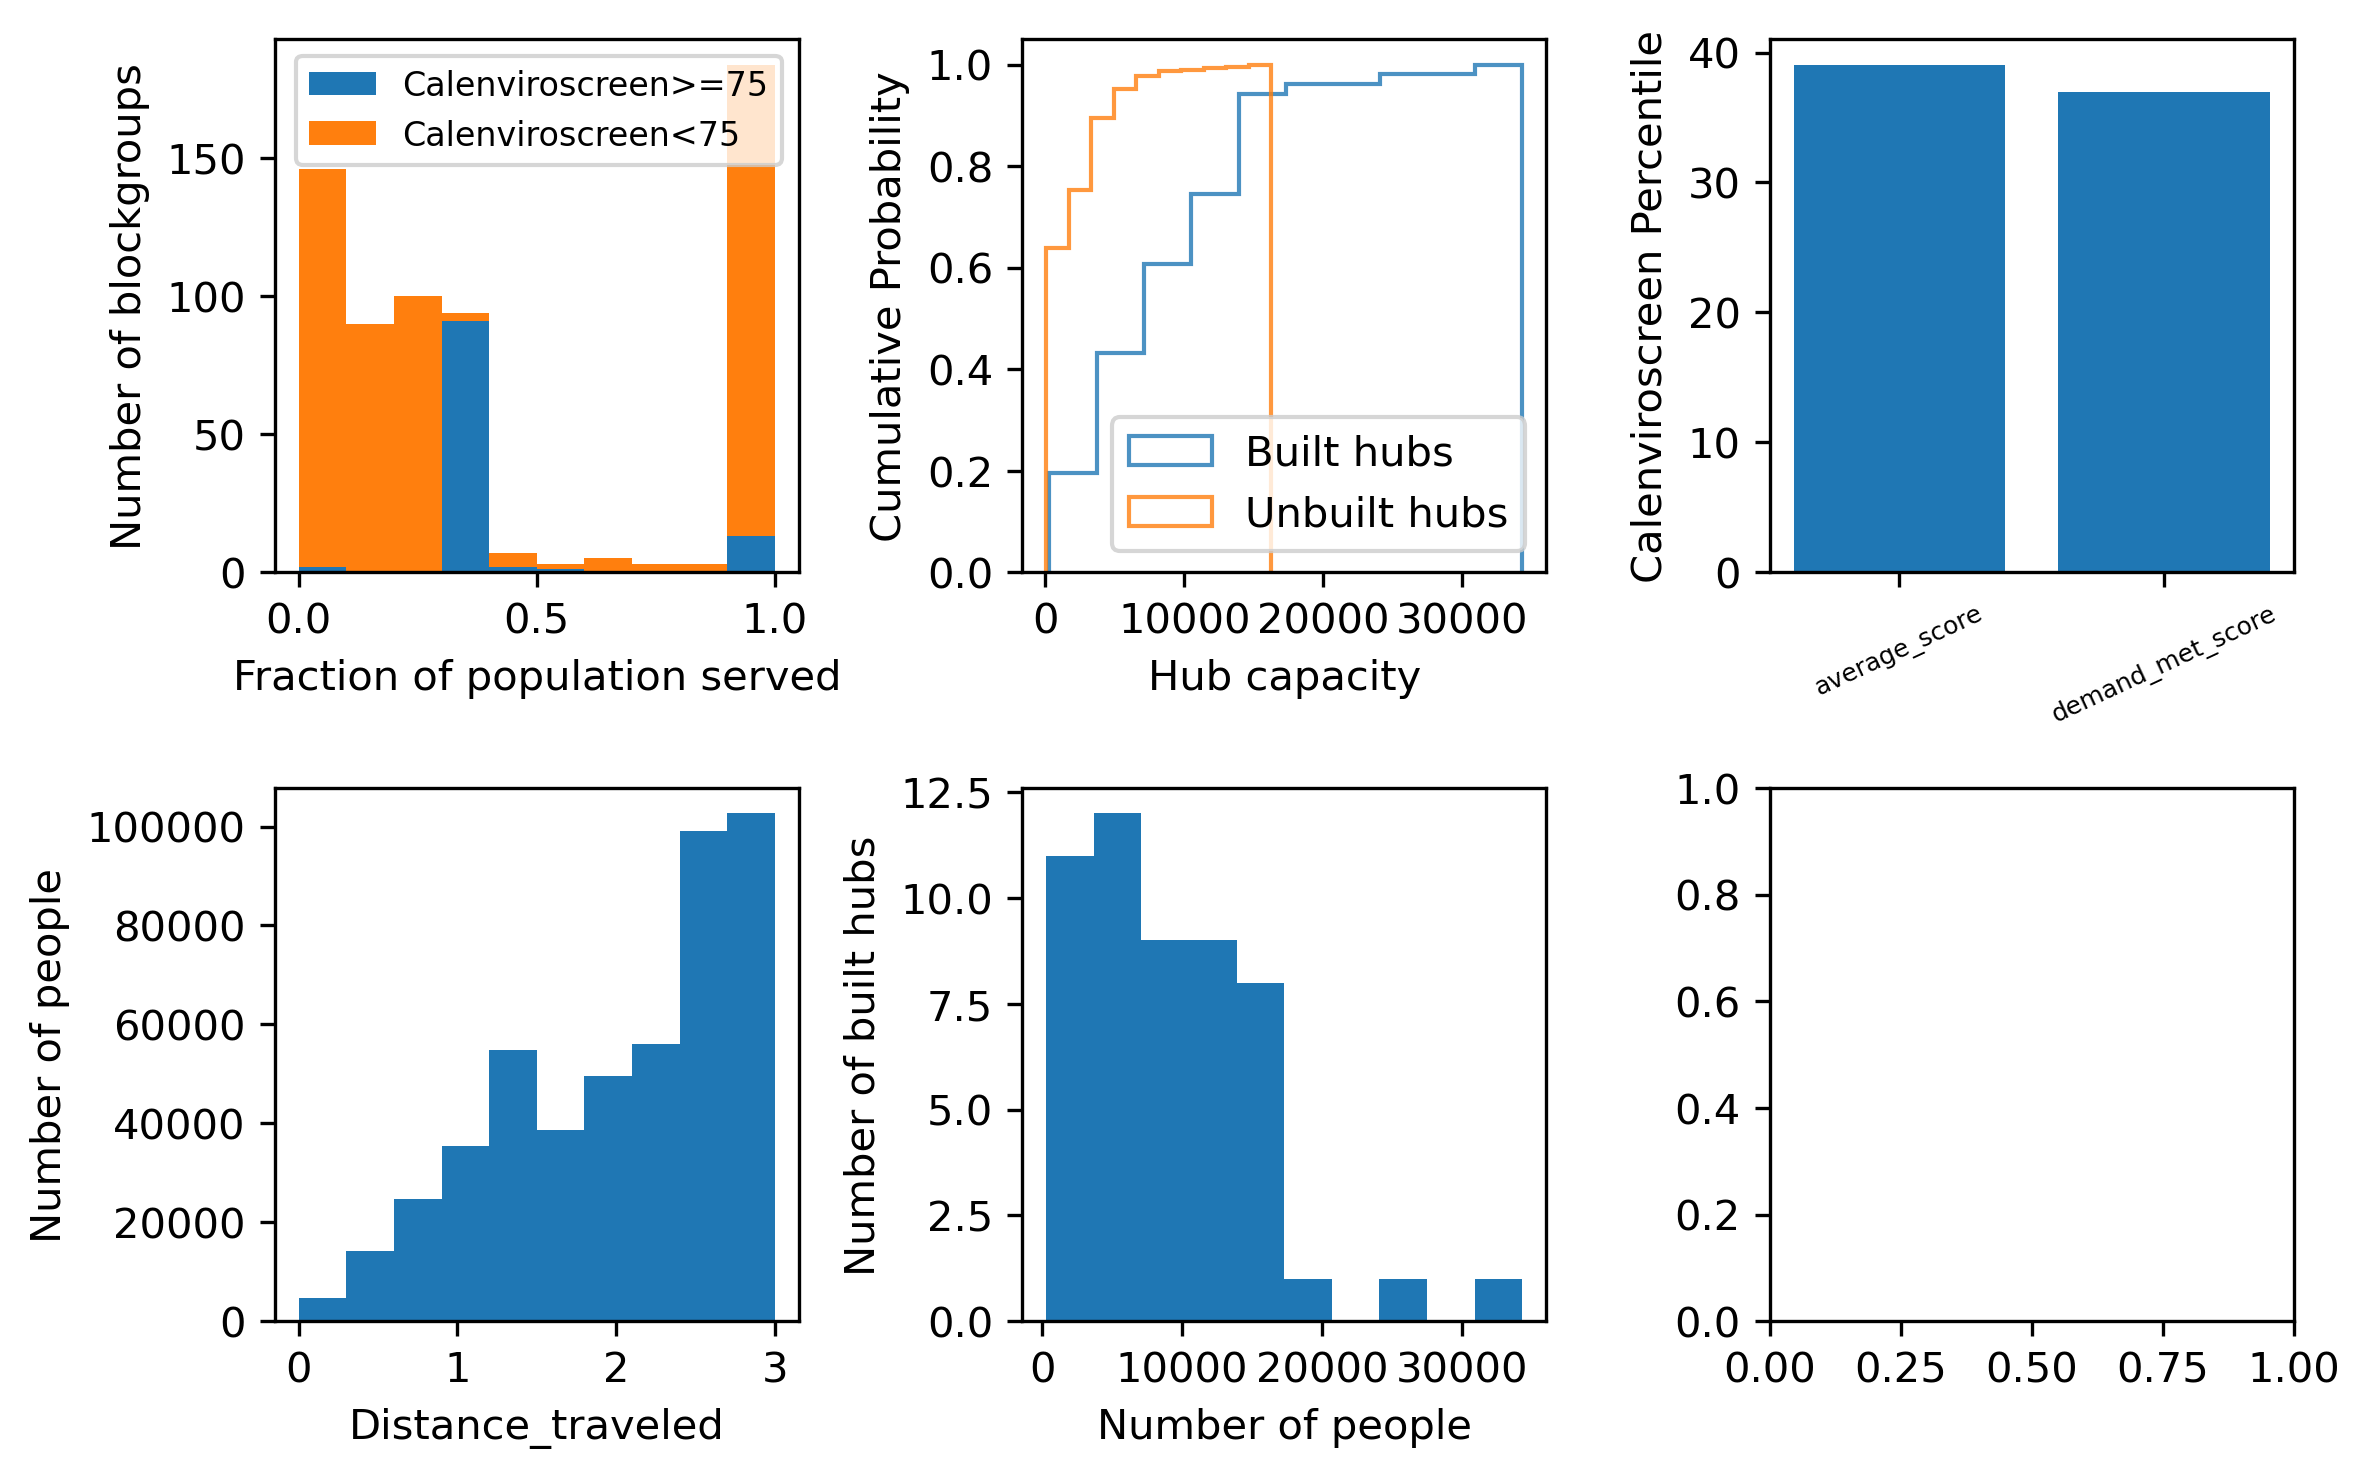

In [176]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3,figsize = (8,5),dpi=300)

################USER VARIABLES#####################
# Change this section however you like, it just needs to get the
# two variables var_prop_served and var_hub_yn in order to work
max_cost_entry = 1
max_distance_entry = 0
ces_multiplier = 1

max_cost = max_cost_list[max_cost_entry]
max_distance = max_distance_list[max_distance_entry]
ces_multiplier = ces_multiplier_list[ces_multiplier_entry]
var_prop_served = prop_served_dict[(max_cost,max_distance,ces_multiplier)]
var_hub_yn = hub_yn_dict[(max_cost,max_distance,ces_multiplier)]
###################################################

# GETTING DATA FROM VARIABLES
hubs_not_built = var_hub_yn.index[var_hub_yn[0]==0]
hubs_not_built = [str(h) for h in hubs_not_built if str(h) in var_prop_served.columns]
hubs_not_built_df = hubs_df.loc[hubs_not_built,:]

hubs_built = var_hub_yn.index[var_hub_yn[0]==1]
hubs_built = [str(h) for h in hubs_built if str(h) in var_prop_served.columns]
hubs_built_df = hubs_df.loc[hubs_built,:]

blockgroup_df_local = blockgroup_df.loc[var_prop_served.index.to_list(),:].copy()
blockgroup_df_local = blockgroup_df_local.merge(bg_ces_df,left_index=True,right_index=True)
# blockgroup_df_local.set_index("GISJOIN",inplace=True)

####################################################
# BLOCKGROUP TOTAL DEMAND MET HISTOGRAMS
EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]>=75]["GISJOIN"].to_list()]
not_EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]<75]["GISJOIN"].to_list()]

axs[0,0].hist([var_prop_served.loc[EJ_bg].sum(axis=1),
                var_prop_served.loc[not_EJ_bg].sum(axis=1)],
                label = ("Calenviroscreen>=75","Calenviroscreen<75"),
                stacked=True, # histtype=u'step'
                )
axs[0,0].legend(fontsize = 8)
axs[0,0].set_xlabel("Fraction of population served")
axs[0,0].set_ylabel("Number of blockgroups")

####################################################
# CDF OF HUB CAPCITIES
axs[0,1].hist([hub_occ_dict[hub] for hub in hubs_built], density=True, cumulative=True, label='Built hubs',histtype='step', alpha=0.8)
axs[0,1].hist([hub_occ_dict[hub] for hub in hubs_not_built], density=True, cumulative=True, label='Unbuilt hubs',histtype='step', alpha=0.8)
axs[0,1].legend(loc='lower right')
axs[0,1].set_xlabel("Hub capacity")
axs[0,1].set_ylabel("Cumulative Probability")
plt.tight_layout()

####################################################
# Calenviroscreen percentiles
total_fraction_demand_met = var_prop_served.sum(axis=1)
total_fraction_demand_met.rename("total_fraction_demand_met",inplace=True)
blockgroup_df_local = blockgroup_df_local.merge(total_fraction_demand_met,left_index=True,right_index=True)
score_dict = dict()
score_dict["average_score"] = np.sum(blockgroup_df_local["SCORE_PCTL_CI_BG"]*(blockgroup_df_local["BLOCKGROUPPOP19"]/np.sum(blockgroup_df_local["BLOCKGROUPPOP19"])))
score_dict["demand_met_score"] = np.sum(blockgroup_df_local["SCORE_PCTL_CI_BG"]*((blockgroup_df_local["total_fraction_demand_met"]*blockgroup_df_local["BLOCKGROUPPOP19"])/(np.sum(blockgroup_df_local["total_fraction_demand_met"]*blockgroup_df_local["BLOCKGROUPPOP19"]))))
axs[0,2].bar(range(len(score_dict)),list(score_dict.values()),tick_label = list(score_dict.keys()))
axs[0,2].set_ylabel("Calenviroscreen Percentile")
axs[0,2].tick_params(axis='x', labelrotation= 25,labelsize=6)

####################################################
# Distance travelled
dist_list = []
pop_list = []
for bg,row in var_prop_served.iterrows():
    for hub in row[row>0].index:
        dist_list.append(distmatrix_df.loc[bg,hub])
        pop_list.append(cengeo_pop_dict[bg]*var_prop_served.loc[bg,hub])

axs[1,0].hist(dist_list,weights = pop_list)
axs[1,0].set_ylabel("Number of people")
axs[1,0].set_xlabel("Distance_traveled")

####################################################
# People per hub
hub_pop_list = []
for hub,row in var_prop_served.iteritems():
    pop = 0
    for bg in row[row>0].index:
        pop+=cengeo_pop_dict[bg]*var_prop_served.loc[bg,hub]
    if pop>0:
        hub_pop_list.append(pop)

axs[1,1].hist(hub_pop_list)
axs[1,1].set_ylabel("Number of built hubs")
axs[1,1].set_xlabel("Number of people")

plt.tight_layout()
plt.savefig("plots_cost_"+str(max_cost)+"_max_distance"+str(max_distance)+"_ces_"+str(ces_multiplier)+".png")


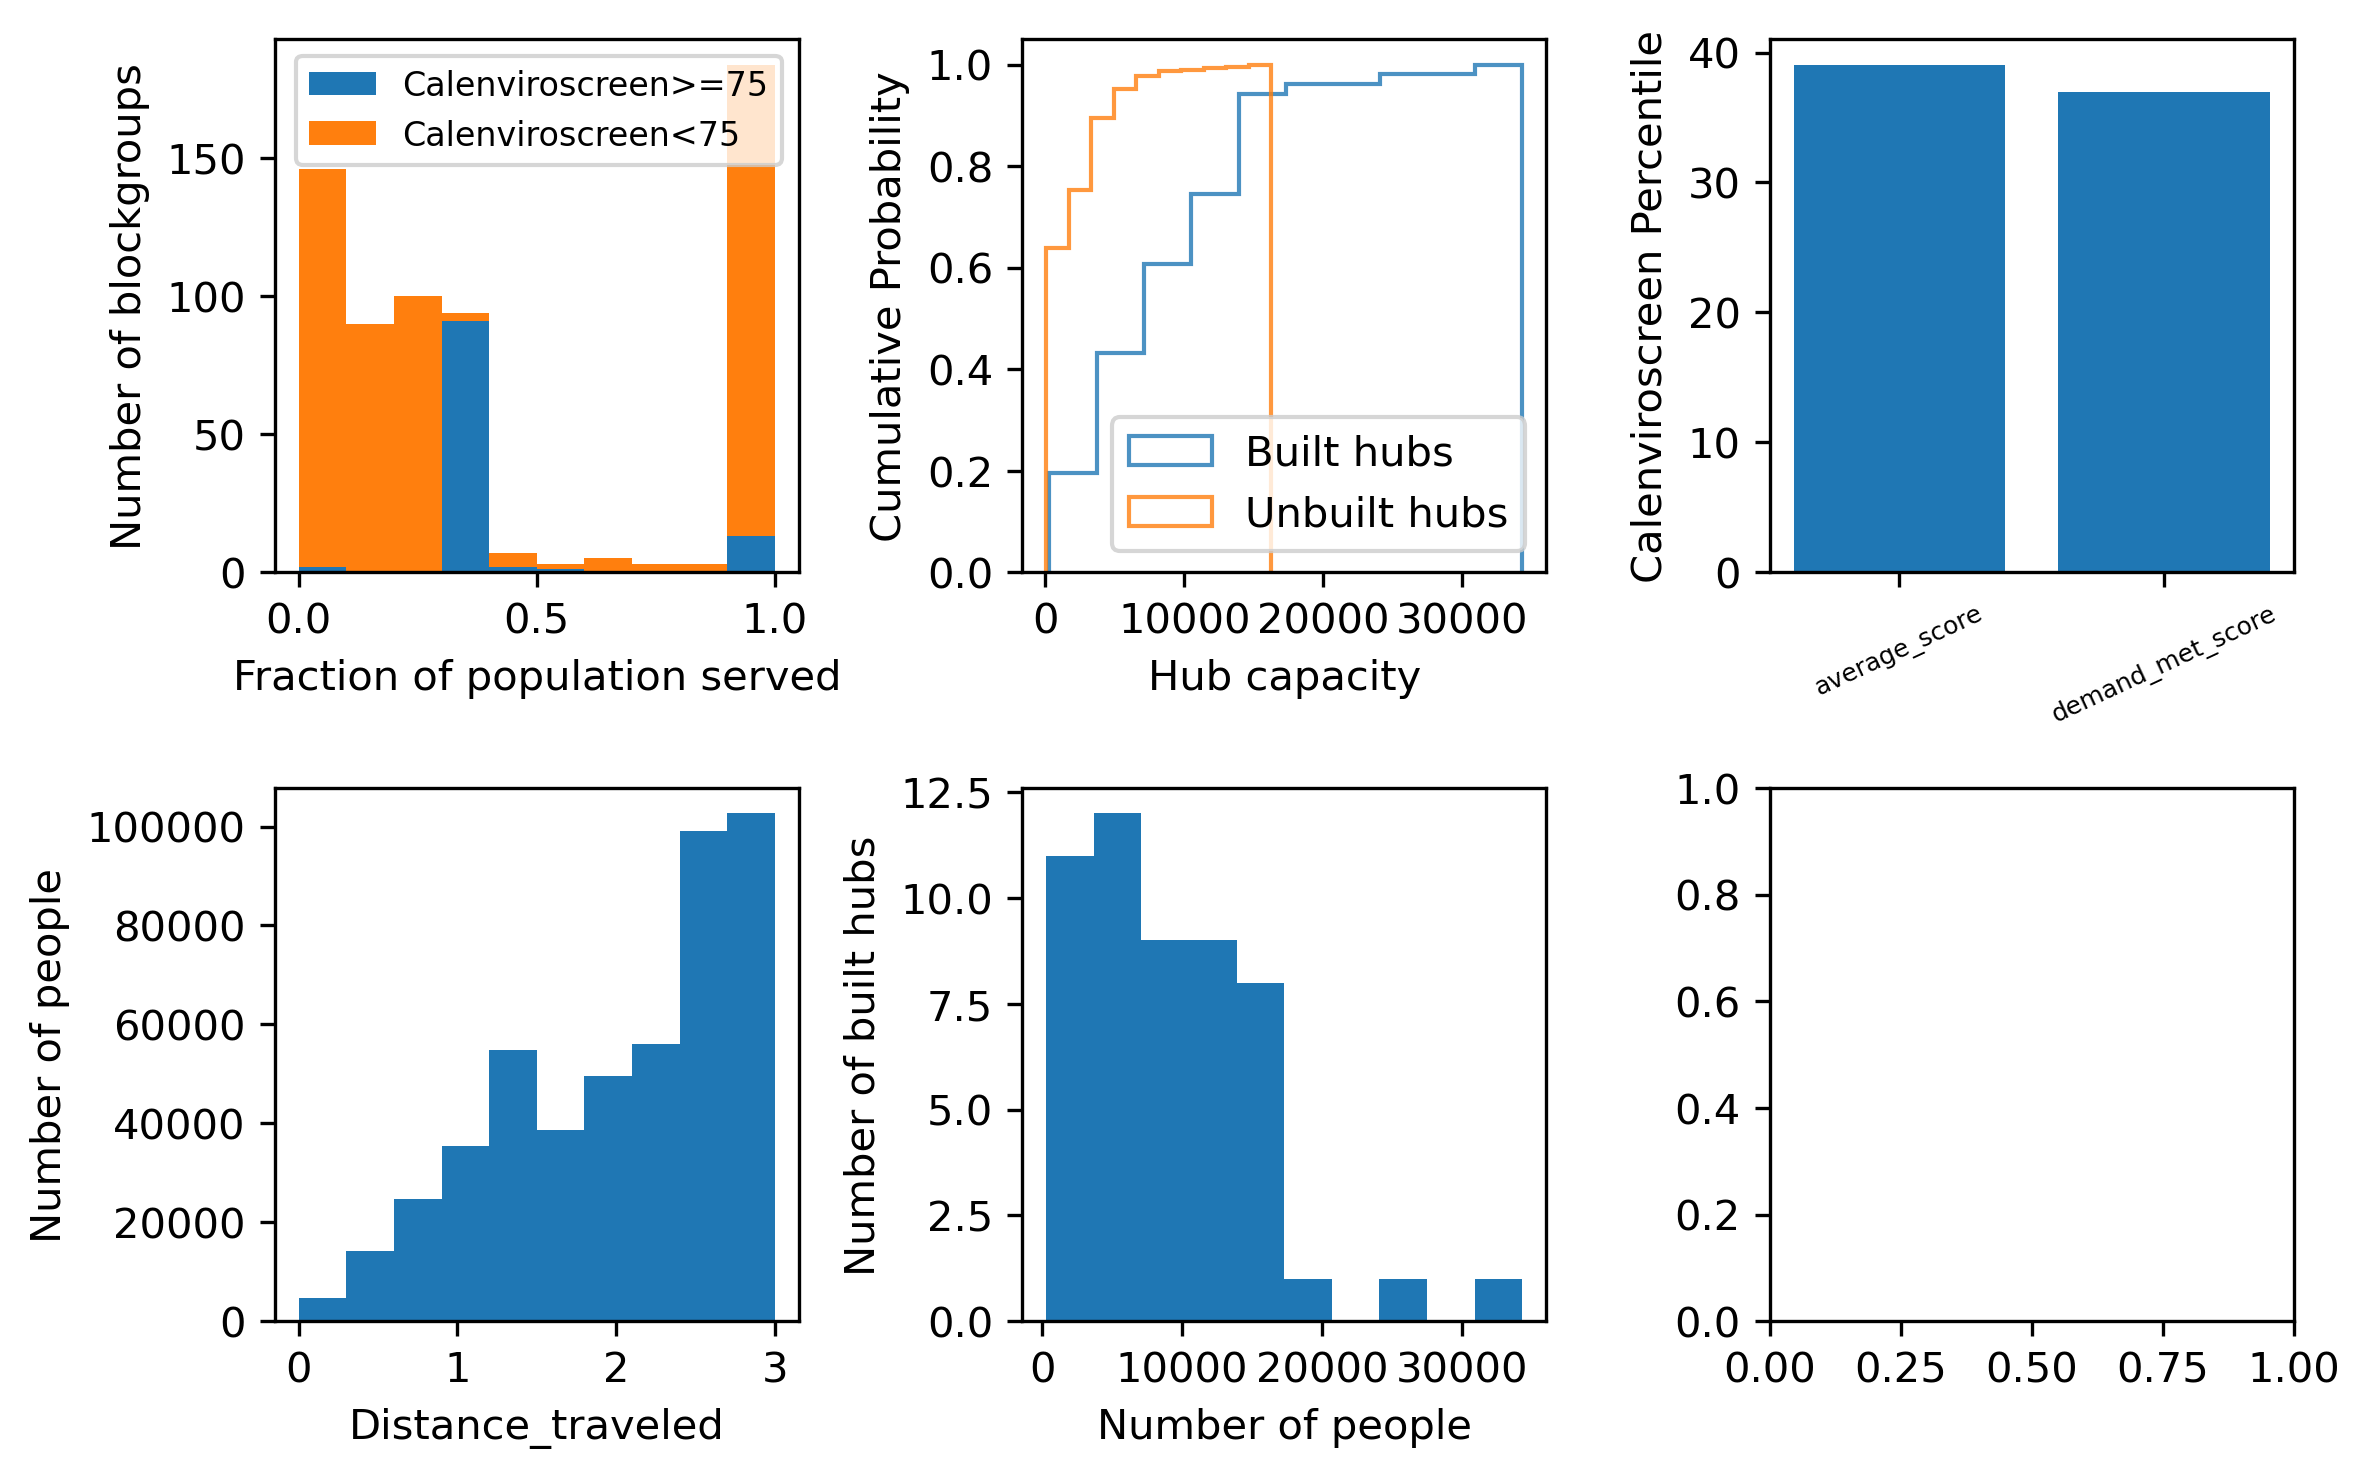

In [178]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3,figsize = (8,5),dpi=300)

################USER VARIABLES#####################
# Change this section however you like, it just needs to get the
# two variables var_prop_served and var_hub_yn in order to work
max_cost_entry = 1
max_distance_entry = 0
ces_multiplier = 0

max_cost = max_cost_list[max_cost_entry]
max_distance = max_distance_list[max_distance_entry]
ces_multiplier = ces_multiplier_list[ces_multiplier_entry]
var_prop_served = prop_served_dict[(max_cost,max_distance,ces_multiplier)]
var_hub_yn = hub_yn_dict[(max_cost,max_distance,ces_multiplier)]
###################################################

# GETTING DATA FROM VARIABLES
hubs_not_built = var_hub_yn.index[var_hub_yn[0]==0]
hubs_not_built = [str(h) for h in hubs_not_built if str(h) in var_prop_served.columns]
hubs_not_built_df = hubs_df.loc[hubs_not_built,:]

hubs_built = var_hub_yn.index[var_hub_yn[0]==1]
hubs_built = [str(h) for h in hubs_built if str(h) in var_prop_served.columns]
hubs_built_df = hubs_df.loc[hubs_built,:]

blockgroup_df_local = blockgroup_df.loc[var_prop_served.index.to_list(),:].copy()
blockgroup_df_local = blockgroup_df_local.merge(bg_ces_df,left_index=True,right_index=True)
# blockgroup_df_local.set_index("GISJOIN",inplace=True)

####################################################
# BLOCKGROUP TOTAL DEMAND MET HISTOGRAMS
EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]>=75]["GISJOIN"].to_list()]
not_EJ_bg = [bg for bg in var_prop_served.index if bg in bg_ces_df[bg_ces_df["SCORE_PCTL_CI_BG"]<75]["GISJOIN"].to_list()]

axs[0,0].hist([var_prop_served.loc[EJ_bg].sum(axis=1),
                var_prop_served.loc[not_EJ_bg].sum(axis=1)],
                label = ("Calenviroscreen>=75","Calenviroscreen<75"),
                stacked=True, # histtype=u'step'
                )
axs[0,0].legend(fontsize = 8)
axs[0,0].set_xlabel("Fraction of population served")
axs[0,0].set_ylabel("Number of blockgroups")

####################################################
# CDF OF HUB CAPCITIES
axs[0,1].hist([hub_occ_dict[hub] for hub in hubs_built], density=True, cumulative=True, label='Built hubs',histtype='step', alpha=0.8)
axs[0,1].hist([hub_occ_dict[hub] for hub in hubs_not_built], density=True, cumulative=True, label='Unbuilt hubs',histtype='step', alpha=0.8)
axs[0,1].legend(loc='lower right')
axs[0,1].set_xlabel("Hub capacity")
axs[0,1].set_ylabel("Cumulative Probability")
plt.tight_layout()

####################################################
# Calenviroscreen percentiles
total_fraction_demand_met = var_prop_served.sum(axis=1)
total_fraction_demand_met.rename("total_fraction_demand_met",inplace=True)
blockgroup_df_local = blockgroup_df_local.merge(total_fraction_demand_met,left_index=True,right_index=True)
score_dict = dict()
score_dict["average_score"] = np.sum(blockgroup_df_local["SCORE_PCTL_CI_BG"]*(blockgroup_df_local["BLOCKGROUPPOP19"]/np.sum(blockgroup_df_local["BLOCKGROUPPOP19"])))
score_dict["demand_met_score"] = np.sum(blockgroup_df_local["SCORE_PCTL_CI_BG"]*((blockgroup_df_local["total_fraction_demand_met"]*blockgroup_df_local["BLOCKGROUPPOP19"])/(np.sum(blockgroup_df_local["total_fraction_demand_met"]*blockgroup_df_local["BLOCKGROUPPOP19"]))))
axs[0,2].bar(range(len(score_dict)),list(score_dict.values()),tick_label = list(score_dict.keys()))
axs[0,2].set_ylabel("Calenviroscreen Percentile")
axs[0,2].tick_params(axis='x', labelrotation= 25,labelsize=6)

####################################################
# Distance travelled
dist_list = []
pop_list = []
for bg,row in var_prop_served.iterrows():
    for hub in row[row>0].index:
        dist_list.append(distmatrix_df.loc[bg,hub])
        pop_list.append(cengeo_pop_dict[bg]*var_prop_served.loc[bg,hub])

axs[1,0].hist(dist_list,weights = pop_list)
axs[1,0].set_ylabel("Number of people")
axs[1,0].set_xlabel("Distance_traveled")

####################################################
# People per hub
hub_pop_list = []
for hub,row in var_prop_served.iteritems():
    pop = 0
    for bg in row[row>0].index:
        pop+=cengeo_pop_dict[bg]*var_prop_served.loc[bg,hub]
    if pop>0:
        hub_pop_list.append(pop)

axs[1,1].hist(hub_pop_list)
axs[1,1].set_ylabel("Number of built hubs")
axs[1,1].set_xlabel("Number of people")

plt.tight_layout()
plt.savefig("plots_cost_"+str(max_cost)+"_max_distance"+str(max_distance)+"_ces_"+str(ces_multiplier)+".png")
